# File to generate field interpolated on SWOT tracks (for computing 2D spectrum)

This notebook interpolates a dataset (reconstruction or reference field) under the SWOT swath, with a timestep of 1 hour. It is useful to generate 2 spatial spectrum along SWOT track, under the SWOT swath measurement. 

In [1]:
import numpy as np 
import xarray as xr
import glob 
import os 
from scipy import interpolate
import random
import datetime

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import gc

from joblib import Parallel
from joblib import delayed as jb_delayed


Refer the satellite type data in the variable *sat_type*, either **wide_swath** for swath measurements, or **nadir** for nadir measurements. 

In [2]:
sat_type = "wide_swath"

Choice of the OSSE zone between *crossover_CCS*, *crossover_centerpacific* and *crossover_hawaii*.

In [3]:
zone = "hawaii"

Choice of the variables to integrate in the interpolated measurements among : 
- *ssh_cor* : Total DAC corrected SSH, renamed *ssh* in the output dataset 
- *ssh_bm* : Balanced Motion,
- *ssh_it1* : 1st Mode Internal Tide, 
- *ssh_it2* : 2nd Mode Internal Tide, 
- *ssh_it3* : 3d Mode Internal Tide, 
- *ssh_it_tot* : Total Internal Tide,
- *ssh_it1_coherent* : Coherent part of the 1st Mode Internal Tide. 

In [4]:
list_variables = ["ssh_bm","ssh_it","ssh"]
dic_attrs = dict({"ssh_bm":"Balanced Motion.",
                  "ssh_it":"1st Mode Internal Tide.",
                  "ssh":"Total SSH."})

Definition of the coordinates limits : 

In [5]:
if zone == "crossover_CCS":
    lon_min = 225; lon_max = 245;lat_min = 25; lat_max = 45;
elif zone == "crossover_centerpacific":
    lon_min = 200; lon_max = 220;lat_min = 25; lat_max = 45;
elif zone == "crossover_hawaii":
    lon_min = 180; lon_max = 200;lat_min = 25; lat_max = 45;
elif zone == "hawaii":
    # lon_min = 185; lon_max = 205;lat_min = 15; lat_max = 35;
    lon_min = 190; lon_max = 200;lat_min = 20; lat_max = 30;

## 1. - Processing Dataset used for interpolation (the reconstructed or reference field)

#### Loading 

QG reconstruction 

In [8]:
ds_QG = xr.open_mfdataset("/bettik/bellemva/MASSH_outputs/final_experiment_hawaii_itg/config_QG/*.nc")
ssh_bm_QG = ds_QG.ssh_bm.load()
ssh_bm_QG = ssh_bm_QG.rename({"lon":"longitude","lat":"latitude"})

QG/SW reconstruction 

In [9]:
ds_QGSW = xr.open_mfdataset("/bettik/bellemva/MASSH_outputs/final_experiment_hawaii_itg/config_QGSW/*.nc")
# - BALANCED MOTIONS BM - #
ssh_bm_QGSW = ds_QGSW.ssh_bm.load()
ssh_bm_QGSW = ssh_bm_QGSW.rename({"lon":"longitude","lat":"latitude"})
# - INTERNAL TIDE IT - #
ssh_it_QGSW = ds_QGSW.ssh_it.load()
ssh_it_QGSW = ssh_it_QGSW.rename({"lon":"longitude","lat":"latitude"})

QG/SW reconstruction 

In [10]:
ds_QGSW_notime = xr.open_mfdataset("/bettik/bellemva/MASSH_outputs/final_experiment_hawaii_itg/config_QGSW_notime/*.nc")
# - BALANCED MOTIONS BM - #
ssh_bm_QGSW_notime = ds_QGSW_notime.ssh_bm.load()
ssh_bm_QGSW_notime = ssh_bm_QGSW_notime.rename({"lon":"longitude","lat":"latitude"})
# - INTERNAL TIDE IT - #
ssh_it_QGSW_notime = ds_QGSW_notime.ssh_it.load()
ssh_it_QGSW_notime = ssh_it_QGSW_notime.rename({"lon":"longitude","lat":"latitude"})

#### Creating the interpolator 

In [11]:
## QG MODEL ## 
ssh_bm_QG_interpolator = interpolate.RegularGridInterpolator([ssh_bm_QG.time.values.astype("float64"),ssh_bm_QG.latitude.values,ssh_bm_QG.longitude.values],
                                    ssh_bm_QG.values,
                                    bounds_error=False)

## QG/SW MODEL ## 
ssh_bm_QGSW_interpolator = interpolate.RegularGridInterpolator([ssh_bm_QGSW.time.values.astype("float64"),ssh_bm_QGSW.latitude.values,ssh_bm_QGSW.longitude.values],
                                    ssh_bm_QGSW.values,
                                    bounds_error=False)
ssh_it_QGSW_interpolator = interpolate.RegularGridInterpolator([ssh_it_QGSW.time.values.astype("float64"),ssh_it_QGSW.latitude.values,ssh_it_QGSW.longitude.values],
                                    ssh_it_QGSW.values,
                                    bounds_error=False)

## QG/SW MODEL NO TIME ## 
ssh_bm_QGSW_notime_interpolator = interpolate.RegularGridInterpolator([ssh_bm_QGSW_notime.time.values.astype("float64"),ssh_bm_QGSW_notime.latitude.values,ssh_bm_QGSW_notime.longitude.values],
                                    ssh_bm_QGSW_notime.values,
                                    bounds_error=False)
ssh_it_QGSW_notime_interpolator = interpolate.RegularGridInterpolator([ssh_it_QGSW_notime.time.values.astype("float64"),ssh_it_QGSW_notime.latitude.values,ssh_it_QGSW_notime.longitude.values],
                                    ssh_it_QGSW.values,
                                    bounds_error=False)

## 2. - SWOT data processing 

The information of SWOT swaths coordinates are dowloaded. The file contain the North Pacific region. 

In [12]:
ds = xr.open_dataset("/bettik/bellemva/satellite_track/swot/track_swot_pacific.nc")

if sat_type == "nadir" :
    ds = ds.isel(num_pixels=35)

The file is cropped to only keep the region of interest : 

In [13]:
if "longitude_nadir" in ds.keys() and "latitude_nadir" in ds.keys():
    lon_nad = ds.longitude_nadir
    lat_nad = ds.latitude_nadir
else : 
    lon_nad = ds.longitude
    lat_nad = ds.latitude

### if zone == "hawaii", shifting the crossover coordinates to hawaii ###
if zone=="hawaii":
    # sleecting data from another crossover
    # lon_min_bis = 225; lon_max_bis = 245;lat_min_bis = 25; lat_max_bis = 45;
    lon_min_bis = 230; lon_max_bis = 240;lat_min_bis = 30; lat_max_bis = 40;
    mask = (lon_nad>lon_min_bis)*(lon_nad<lon_max_bis)*(lat_nad>lat_min_bis)*(lat_nad<lat_max_bis)
    
    #shifting coordinates 
    ds = ds.where(mask,drop=True)

    # ds = ds.where(mask)
    ds = ds.assign_coords({"longitude" : ds.longitude - (lon_min_bis - lon_min)})
    ds = ds.assign_coords({"latitude" : ds.latitude - (lat_min_bis - lat_min)})

### else : ### 
else : 
    mask = (lon_nad>lon_min)*(lon_nad<lon_max)*(lat_nad>lat_min)*(lat_nad<lat_max)
    ds = ds.where(mask,drop=True)

A mask is applied to select the measures with across track distance between 10km and 60km, if wide swath type is interpolated. 

In [14]:
if sat_type == "wide_swath" :
    mask_act = np.logical_and(np.abs(ds.cross_track_distance)>10000,
                            np.abs(ds.cross_track_distance)<60000)

    # ds_m = ds.where(mask_act,drop=True)

    # ds_m = ds.copy(deep=True)
    # ds_m["longitude"] = ds["longitude"].where(mask_act)
    # ds_m["latitude"] = ds["latitude"].where(mask_act)
    # ds_m['time'] = ds.time
    # ds = ds_m
    # del ds_m

The SWOT coordinates for the full period are computed from the SWOT coordinates dataset. 

In [15]:
### CREATION OF THE TIME DATASET COOORDINATE ### 
n_days = 92

time_dataset = np.empty((ds_QG.dims["time"]*ds.time.values.shape[0],),dtype="datetime64[ns]")
# time_delta = (ds.time.values-ds.time.values[0])
# shift = np.timedelta64(int(3600*1E9),"ns")

for i in range (ds_QG.dims["time"]) : # number of swot cycles computed, in the 91 days of experiment 
    time_dataset[i*ds.time.values.shape[0]:(i+1)*ds.time.values.shape[0]] = ds_QG.time[i]

### CREATION OF THE LONGITUDE AND LATITUDE DATASET COOORDINATE ### 
longitude_dataset = np.tile(ds.longitude.values.T,reps=ds_QG.dims["time"]).T
latitude_dataset = np.tile(ds.latitude.values.T,reps=ds_QG.dims["time"]).T
if sat_type == "wide_swath" :
    mask_act_dataset = np.tile(mask_act.values.T,reps=ds_QG.dims["time"]).T

/tmp/ipykernel_179917/906291566.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dataset = np.empty((ds_QG.dims["time"]*ds.time.values.shape[0],),dtype="datetime64[ns]")
/tmp/ipykernel_179917/906291566.py:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in range (ds_QG.dims["time"]) : # number of swot cycles computed, in the 91 days of experiment
/tmp/ipykernel_179917/906291566.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dime

In [16]:
time_array = time_dataset
time_array_float = time_array.astype("float64")

time_array_extended = np.repeat(np.expand_dims(time_array,axis=1),axis=1,repeats=69)
time_array_float_extended = np.repeat(np.expand_dims(time_array_float,axis=1),axis=1,repeats=69)

In [17]:
longitude_array = longitude_dataset
latitude_array = latitude_dataset

points = np.concatenate((np.expand_dims(time_array_float_extended.flatten(),axis=1),
                                       np.expand_dims(latitude_array.flatten(),axis=1),
                                       np.expand_dims(longitude_array.flatten(),axis=1)),axis=1)


## 3. - Interpolating the dataset ont the SWOT tracks and saving 

#### Interpolating 

In [24]:
## QG MODEL ##
ssh_bm_QG_interp = ssh_bm_QG_interpolator(points).reshape(time_array_extended.shape)
## QG/SW MODEL ##
ssh_bm_QGSW_interp = ssh_bm_QGSW_interpolator(points).reshape(time_array_extended.shape)
ssh_it_QGSW_interp = ssh_it_QGSW_interpolator(points).reshape(time_array_extended.shape)
## QG/SW NO TIME MODEL ## 
ssh_bm_QGSW_notime_interp = ssh_bm_QGSW_interpolator(points).reshape(time_array_extended.shape)
ssh_it_QGSW_notime_interp = ssh_it_QGSW_interpolator(points).reshape(time_array_extended.shape)

#### Masking 

In [41]:
## QG MODEL ##
ssh_bm_QG_interp[~mask_act_dataset] = np.nan
## QG/SW MODEL ##
ssh_bm_QGSW_interp[~mask_act_dataset] = np.nan
ssh_it_QGSW_interp[~mask_act_dataset] = np.nan
## QG/SW NO TIME MODEL ## 
ssh_bm_QGSW_notime_interp[~mask_act_dataset] = np.nan
ssh_it_QGSW_notime_interp[~mask_act_dataset] = np.nan

#### Reshaping into 3D array (with time coordinate) 

In [61]:
## QG MODEL ##
ssh_bm_QG_interp_reshape = ssh_bm_QG_interp.reshape((ds_QG.dims["time"],ds.time.values.shape[0],69))
## QG/SW MODEL ##
ssh_bm_QGSW_interp_reshape = ssh_bm_QGSW_interp.reshape((ds_QG.dims["time"],ds.time.values.shape[0],69))
ssh_it_QGSW_interp_reshape = ssh_it_QGSW_interp.reshape((ds_QG.dims["time"],ds.time.values.shape[0],69))
## QG/SW MODEL NO TIME ##
ssh_bm_QGSW_notime_interp_reshape = ssh_bm_QGSW_notime_interp.reshape((ds_QG.dims["time"],ds.time.values.shape[0],69))
ssh_it_QGSW_notime_interp_reshape = ssh_it_QGSW_notime_interp.reshape((ds_QG.dims["time"],ds.time.values.shape[0],69))

/tmp/ipykernel_179917/3428467676.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ssh_bm_QG_interp_reshape = ssh_bm_QG_interp.reshape((ds_QG.dims["time"],ds.time.values.shape[0],69))
/tmp/ipykernel_179917/3428467676.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ssh_bm_QGSW_interp_reshape = ssh_bm_QGSW_interp.reshape((ds_QG.dims["time"],ds.time.values.shape[0],69))
/tmp/ipykernel_179917/3428467676.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapp

#### Creating the dataset 

In [62]:
## QG MODEL ##
ds_QG_swot_interp = xr.Dataset({"ssh_bm":(['time','num_lines','num_pixels'],ssh_bm_QG_interp_reshape)}, 
                        coords={'latitude':(['num_lines','num_pixels'],ds.latitude.values),
                                'longitude':(['num_lines','num_pixels'],ds.longitude.values),
                                'time':(('time'),ds_QG.time.values)} 
                        )
# ## QG/SW MODEL ##
ds_QGSW_swot_interp = xr.Dataset({"ssh_bm":(['time','num_lines','num_pixels'],ssh_bm_QGSW_interp_reshape),
                                  "ssh_it":(['time','num_lines','num_pixels'],ssh_it_QGSW_interp_reshape)}, 
                        coords={'latitude':(['num_lines','num_pixels'],ds.latitude.values),
                                'longitude':(['num_lines','num_pixels'],ds.longitude.values),
                                'time':(('time'),ds_QG.time.values)} 
                        )
# ## QG/SW NO TIME MODEL ## 
ds_QGSW_notime_swot_interp = xr.Dataset({"ssh_bm":(['time','num_lines','num_pixels'],ssh_bm_QGSW_notime_interp_reshape),
                                  "ssh_it":(['time','num_lines','num_pixels'],ssh_it_QGSW_notime_interp_reshape)}, 
                        coords={'latitude':(['num_lines','num_pixels'],ds.latitude.values),
                                'longitude':(['num_lines','num_pixels'],ds.longitude.values),
                                'time':(('time'),ds_QG.time.values)} 
                        )

#### Plotting for test 

In [67]:
_ds = ds_QGSW_notime_swot_interp.sel(time=np.datetime64("2012-05-25"))

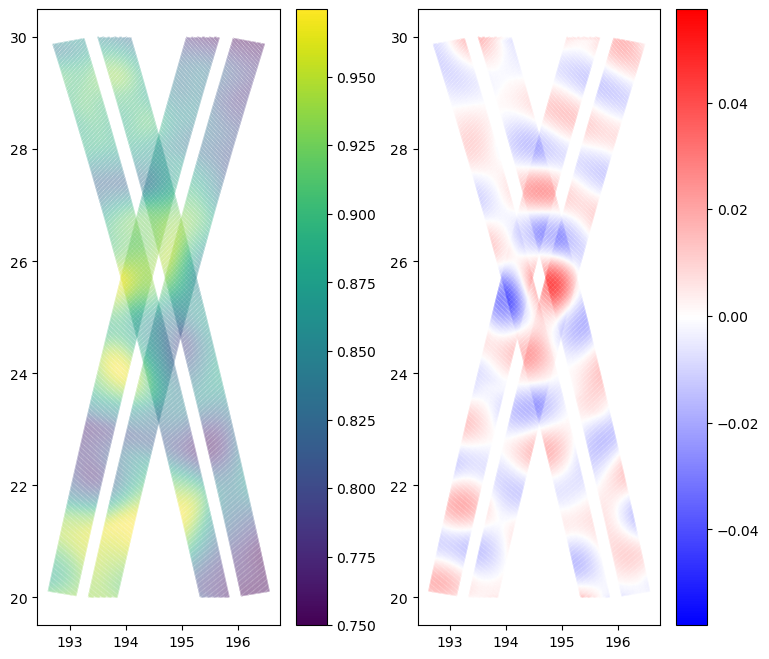

In [68]:
fig,ax = plt.subplots(1,2,figsize=(9,8))

_plt_bm = ax[0].scatter(_ds.longitude,_ds.latitude,s=0.01,c=_ds.ssh_bm.values,cmap='viridis')
ax[0].set_aspect("equal")
fig.colorbar(_plt_bm,ax = ax[0])

_plt_it = ax[1].scatter(_ds.longitude,_ds.latitude,s=0.01,c=_ds.ssh_it.values,cmap='bwr')
ax[1].set_aspect("equal")
fig.colorbar(_plt_it,ax = ax[1])

# _plt_tot = ax[2].scatter(_ds.longitude,_ds.latitude,s=0.01,c=_ds.ssh.values,cmap='viridis')
# ax[2].set_aspect("equal")
# fig.colorbar(_plt_tot,ax = ax[2])

#### Saving the datasets 

In [70]:
ds_QG_swot_interp.to_netcdf("/bettik/bellemva/MASSH_outputs/final_experiment_hawaii_itg/config_QG/reconstruction_swot_interp/reconstruction_swot_interp_config_QG.nc")
ds_QGSW_swot_interp.to_netcdf("/bettik/bellemva/MASSH_outputs/final_experiment_hawaii_itg/config_QGSW/reconstruction_swot_interp/reconstruction_swot_interp_config_QGSW.nc")
ds_QGSW_notime_swot_interp.to_netcdf("/bettik/bellemva/MASSH_outputs/final_experiment_hawaii_itg/config_QGSW_notime/reconstruction_swot_interp/reconstruction_swot_interp_config_QGSW_notime.nc")